## In this lab session we will implement two algorithms (an algorithm for sorting and one for detecting communities) each in two different ways: a naive, less efficient way and a better, faster way

### Fill in the CODE_HERE placeholders and check your code by evaluating the boxes with assert statements

In [1]:
#let us first install the necessary libraries
!pip install matplotlib
!pip install plotly
!pip install networkx

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from collections import defaultdict
from itertools import count

import time
import copy
import numpy as np

import matplotlib.pyplot as plt
import plotly.offline as py
from plotly.offline import init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected=True)

import networkx as nx

### Let's start with the sorting algorithm
We will create multiple data sets of integers we want to sort <br>
Each data set bigger than the previous one <br>
These different sized data sets will be use to emperically determine the complexity of the algorithm

In [3]:
def apply_and_time_sorting(datasets, sort_function):
    datasets = copy.deepcopy(datasets)
    timings = []
    for dataset in datasets:
        start = time.time()
        sort_function(dataset)
        end = time.time()
        time_difference = end - start
        timings.append(time_difference)
    return timings

data_sizes = [5000,10000,20000]

In [4]:
datasets = []
for data_size in data_sizes:
    datasets.append(np.random.permutation(data_size))

### Here we will implement the naive insertion sorting algorithm 
It's an algorithm that sorts an array in-place by iterating over the elements and inserting the current element
in the part of the array that is already sorted

```python
[1,11,13,7,4,8,0]
```

If the current element is 7, then the part of the algorithm before 7 is already sorted by the algorithm <br>
It then tries to find the position to insert the element 7 in the part of the array that is already sorted <br>
Resulting in

```python
[1,7,11,13,4,8,0]
```

The next element to be sorted is 4

In [5]:
def naivesort(data):
    """
    sorts the data in place
    """
    for i, element in enumerate(data):
        j = i
        while j>0 and element<data[j-1]: #iterate back into the array as long as the current element is smaller
            data[j] = data[j-1] #put the bigger element in the position of the current one
            j -= 1
        data[j] = element # store the current element in its sorted position

In [6]:
data = np.random.permutation(10)
naivesort(data)
assert np.all(data == np.array([0,1,2,3,4,5,6,7,8,9]))

In [7]:
timings_slow = apply_and_time_sorting(datasets, naivesort)
print(timings_slow)

[3.374497890472412, 13.64414119720459, 54.22790861129761]


### Let's compare this with the quicksort algorithm that was discussed in class

In [8]:
datasets = []
for data_size in data_sizes:
    datasets.append(np.random.permutation(data_size))

In [9]:
def swap(l, i, j):
    tmp = l[j]
    l[j] = l[i]
    l[i] = tmp

def quicksort_helper(l, starti, endi):
    #set_trace()
    if starti >= endi:
        return
    if endi-starti+1<=100:
        naivesort(l)
    else:
        middlei = int(0.5*(starti+endi))
        #first make sure the start, middle and end element are in sorted order
        if (l[middlei]<l[starti]):
            swap(l,starti, middlei)
        if (l[endi]<l[starti]):
            swap(l, starti, endi)
        if (l[endi]<l[middlei]):
            swap(l, middlei, endi)
        pivoti = middlei
        
        #put the pivot element just before the last 
        swap(l, pivoti, endi-1)
        pivot = l[endi-1]
        lefti = starti+1
        righti = endi-2
        
        #now make sure the elements are partially sorted,
        #i.e. elements in the first half should be smaller than the pivot element
        #the elements in the second half should be larger than the pivot element
        while True:
            while l[lefti]<pivot: #move the cursor from left to right until you encounter an element larger than the pivot
                lefti += 1
            while pivot<l[righti]: #move the cursor from right to left until you encounter an element larger than the pivot
                righti -= 1
            if lefti < righti: #the right element should be smaller than the left element, swap them 
                swap(l, lefti, righti)
            else:
                break
                
        pivoti = lefti
        swap(l, pivoti, endi-1)
        #recursive sort the first half of the array
        quicksort_helper(l, starti, pivoti-1)
        #recursive sort the second half of the array
        quicksort_helper(l, pivoti+1, endi)
        
def quicksort(l):
    quicksort_helper(l, 0, len(l)-1)

In [10]:
data = np.random.permutation(10)
quicksort(data)
assert np.all(data == np.array([0,1,2,3,4,5,6,7,8,9]))

In [11]:
timings_fast = apply_and_time_sorting(datasets, quicksort)
print(timings_fast)

[1.2157397270202637, 5.089610576629639, 19.029390573501587]


In [13]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_sizes,
                y=timings_slow,
                mode='lines',
                name='slow'))
fig.add_trace(go.Scatter(x=data_sizes,
                y=timings_fast,
                mode='lines',
                name='fast'))
fig.show()

## The next algorithm we will investigate is the community detection algorithm: the Louvain method

### As a simple example we will take the social network of a karate club collected by Zachary, the members have a link between them in case they interacted with each other outside the club. The goal is to find the communities that exist in the club

In [3]:
file = "./data/karate_edges_78.txt"

### Let's first create the adjacency matrix for the social network

In [4]:
def create_adjacency_matrix(file):
    node_neighbors = defaultdict(list)

    with open(file, "r") as fin:
        for line in fin:
            node_1, node_2 = line.strip().split('\t')
            node_1 = int(node_1)-1 #offset to make the integers start from zero
            node_2 = int(node_2)-1
            node_neighbors[node_1].append(node_2)

    number_of_nodes = len(node_neighbors)
    A = np.zeros((number_of_nodes, number_of_nodes))

    for node, neighbors in node_neighbors.items():
        for neighbor in neighbors:
            A[node, neighbor] = 1

    return A

In [5]:
A = create_adjacency_matrix(file)

### Compute the total sum of edges in the adjacency matrix A (divided by 2)
Hint: use np.sum

In [6]:
m = 0.5*np.sum(A)

### Let's now define a function to compute the modularity of the network given the adjacency matrix A, the communities and the total sum of edge weights

In [7]:
def compute_modularity(A, communities, m):
    """
    A: dense square matrix, nonzero element on row i and column j indicating 
        a weighted connection between vertex i and j
    communities: vector of communities, on position i the community for node i, so the length of the list equals 
        the number of nodes in the graph
    m: an integer that equals the sum of all edges in the graph divided by two
    """
    nrows, ncols = A.shape
    assert nrows == ncols
    nvertices = nrows

    modularity = 0.0
    for vertexi in range(nvertices):
        for vertexj in range(nvertices):
            if communities[vertexi] == communities[vertexj]:
                ki = np.sum(A[vertexi,:])
                kj = np.sum(A[vertexj,:])
                modularity += A[vertexi, vertexj] - (ki*kj)/(2*m)

    return modularity/(2*m)

### Compute the modularity putting every vertex/node in its own community

The community vector has the same length as the number of vertices/nodes in the graph <br>
Position i in the community vector defines the community of vertex/node i <br>
e.g. [0,0,1,1,1] means the first two vertices belong the community 0 and the last three to community 1

In [8]:
def initialize_communities(n_vertices):
    return np.arange(0,n_vertices) # use np.arange to create a vector from 0 to n_vertices-1
    
initial_communities = initialize_communities(A.shape[0])

### Now compute the modularity for the given adjancency matrix, the initial communities and the total sum of edges

In [9]:
initial_modularity = compute_modularity(A, initial_communities, m)

In [10]:
assert initial_modularity == -0.04980276134122286

### Now we will implement the first phase of the Louvain method but using a naive, inefficient way of computing the modularity difference

Let's first define some helper function to perform the local search (i.e. the first phase) <br>

The first helper function let's us compute the difference in modularity when we move a node from its current
community into another community <br>

We will (on purpose) compute this in a very naive inefficient way

In [11]:
def modularity_difference(A, communities, m, modularity, vertex, community):
    """
    A: the adjacency matrix of the graph
    communities: vector of communities, on position i the community for node i, so the length of the list equals 
        the number of nodes in the graph 
    m: an integer that equals the sum of all edges in the graph divided by two
    modularity: the modularity of the graph A with communities defined by the variable communities
    vertex: the index of the vertex/node you want to compute the modularity difference for when moving it to community
    community: the community to which you want move the vertex
    """
    #store the vertex' community in a variable
    original_community = communities[vertex] 
    #change community of the current vertex
    communities[vertex] = community
    #compute the new modularity
    new_modularity = compute_modularity(A, communities, m)
    #compute the difference between the new modulariy and the old one
    modularity_difference = new_modularity-modularity
    #restore original community of the vertex
    communities[vertex] = original_community
    return modularity_difference

In [12]:
test_A = np.array([
    [0,1,1,0,0,0],
    [1,0,1,0,1,0],
    [1,1,0,0,0,0],
    [0,0,0,0,1,1],
    [0,1,0,1,0,1],
    [0,0,0,1,1,0]
    ]
)
test_communities = np.arange(0,6)
test_m = 0.5*np.sum(A)
test_mod = compute_modularity(test_A, test_communities, test_m)
expected = [
    (0.0,0.0), 
    (0.012327416173,0.012327416174), 
    (0.012491781722,0.012491781723), 
    (-0.00032873110,-0.00032873109), 
    (-0.00049309665,-0.00049309664), 
    (-0.00032873110,-0.00032873109)
]
for vertexi in range(0,6):
    mod_diff = modularity_difference(test_A, test_communities, test_m, test_mod, 0, vertexi)
    lb, ub = expected[vertexi]
    assert lb <= mod_diff <= ub

### Now use the modularity_difference function to iterate over all communities and see which community for the given vertex gives the biggest increase in modularity

In [13]:
def find_best_community(A, communities, m, modularity, vertex):
    """
    A: the adjacency matrix of the graph
    communities: vector of communities, on position i the community for node i, so the length of the list equals 
        the number of nodes in the graph 
    m: an integer that equals the sum of all edges in the graph divided by two
    modularity: the modularity of the graph A with communities defined by the variable communities
    vertex: the index of the vertex/node for which you want to find the best community
    """    
    unique_communities = np.unique(communities)
    max_modularity_difference = 0
    best_community = communities[vertex]
    for community in unique_communities:
        #compute the modularity difference for the given vertex and the community by apply the 
        #before defined modularity_difference function
        modularity_diff = modularity_difference(A, communities, m, modularity, vertex, community)
        #print(f"moving {vertex} from {communities[vertex]} to {community}: {modularity_diff}")
        #if the difference is larger than the maximum modularity difference, store the new difference
        #and set the best_community variable to this new community
        if modularity_diff > max_modularity_difference:
            max_modularity_difference = modularity_diff
            best_community = community
    return best_community, max_modularity_difference

In [14]:
test_A = np.array([
    [0,1,1,0,0,0],
    [1,0,1,0,1,0],
    [1,1,0,0,0,0],
    [0,0,0,0,1,1],
    [0,1,0,1,0,1],
    [0,0,0,1,1,0]
    ]
)
test_communities = np.arange(0,6)
test_m = 0.5*np.sum(A)
test_mod = compute_modularity(test_A, test_communities, test_m)
assert find_best_community(test_A, test_communities, test_m, test_mod, 0)[0] == 2
assert find_best_community(test_A, test_communities, test_m, test_mod, 4)[0] == 3

### We will now use the find_best_community function to keep iterating over all nodes until we can't increase the modularity anymore

In [15]:
def reset_communities(communities):
    """
    reset the community vector so that the communities  start from zero
    
    Example:
    --------
    communities = [17,17,3,17,3,1,1,1,3,17]
    reset_communities(communities) == [0,0,1,0,1,2,2,2,1,0]
    """
    counter = count()
    community_mapper = defaultdict(lambda: next(counter))
    reset_communities = np.zeros((len(communities),), dtype=int)
    for vertex, community in enumerate(communities):
        reset_communities[vertex] = community_mapper[community]
    return reset_communities

def local_search(A, communities, m, modularity, seed=11):
    #we iterate over the vertices in a randomized way
    nvertices = len(communities)
    if seed>0:
        vertex_order = np.random.RandomState(seed=seed).permutation(nvertices)
    else:
        vertex_order = range(nvertices)

    is_modularity_increasing = True
    #keep iterating over the vertices until the modulariy stops increasing
    while is_modularity_increasing:
        is_modularity_increasing = False
        for vertex in vertex_order:
            #find the best community for the vertex using the find_best_community function
            best_community, modularity_difference = find_best_community(A, communities, m, modularity, vertex)
            #print(f"best community for {vertex} ({communities[vertex]}) is {best_community}: {modularity_difference}")
            #if the modulariy is strictly positive set the community of the vertex to the best_community
            if modularity_difference > 0:
                communities[vertex] = best_community
                modularity += modularity_difference #update the modularity with the difference
                is_modularity_increasing = True #set the flag that indicates the modularity is still increasing

    communities = reset_communities(communities) #just reindexing the new communities so they start from zero

    return communities, modularity

In [16]:
test_A = np.array([
    [0,1,1,0,0,0],
    [1,0,1,0,1,0],
    [1,1,0,0,0,0],
    [0,0,0,0,1,1],
    [0,1,0,1,0,1],
    [0,0,0,1,1,0]
    ]
)
test_communities = np.arange(0,6)
test_m = 0.5*np.sum(A)
test_mod = compute_modularity(test_A, test_communities, test_m)
assert np.all(local_search(test_A, test_communities, test_m, test_mod)[0] == np.array([0,0,0,1,1,1]))

### Next we implement the second phase of the Louvain method
This step reduces the network where all nodes, that belong to the same community, are now reduced into one node <br>
The new weight between two nodes is the sum of all the edge weights between their respective communities <br>
The weight of the self-link is the sum of all weights between the original nodes of the community <br>

Example <br>

Original adjacency matrix <br>
```python
    [
        [0,1,1,0],
        [1,0,1,0],
        [1,1,0,1],
        [0,0,1,0]
    ]
```
with communities <br>
```python
    [0,0,0,1]
```
will reduce to <br>
```python
    [
        [6,1],
        [1,0]
    ]
```
with communities <br>
```python
    [0,1]
```

In [17]:
def reduce_network(A, communities):
    #assumes communities starting from zero increasing by one
    unique_communities = np.unique(communities)
    n_communities = len(unique_communities)
    #initialize the new reduced adjacency matrix as a zero square matrix of dimension n_communities
    reduced_A = np.zeros((n_communities, n_communities))

    #now let's fill in all the entries in the reduced_A matrix 
    #(note that this can be done more efficiently because the matrix is symmetric) 
    for communityi in unique_communities:
        for communityj in unique_communities:
            #find all the vertex indices that belong to communityi (hint: don't forget to flatten the array)
            vertices_i = np.argwhere(communities == communityi).flatten()
            #find all the vertex indices that belong to communityj (hint: don't forget to flatten the array)
            vertices_j = np.argwhere(communities == communityj).flatten()
            #select the sub matrix of all the vertices in communityi and communityj
            sub_A = A[vertices_i,:]
            sub_A = sub_A[:,vertices_j]
            #the edge weight between communityi and communityj is the sum of the weights
            #between all the vertices of communities communityi and communityj
            reduced_A[communityi, communityj] = np.sum(sub_A)

    #put each vertex in the reduced network again in its own community
    communities = np.array([i for i in range(reduced_A.shape[0])], dtype=int)
    
    return reduced_A, communities

In [18]:
test_A = np.array([
    [0,1,1,0,0,0],
    [1,0,1,0,1,0],
    [1,1,0,0,0,0],
    [0,0,0,0,1,1],
    [0,1,0,1,0,1],
    [0,0,0,1,1,0]
    ]
)
test_communities = [0,0,0,1,1,1]
assert np.all(reduce_network(test_A, test_communities)[0] == np.array([[6,1],[1,6]]))

### Now we will combine the local_search function and the reduce_function to find the community structure with the highest modularity

In [19]:
def traceback_communities(reduced_communities, communities):
    #assumes community i after local search is also reduced to the i-th node
    new_communities = np.zeros((len(communities,)),dtype=int)
    for vertex, community in enumerate(communities):
        new_communities[vertex] = reduced_communities[community]
    return new_communities

def detect_communities(A, communities):
    m = 0.5*np.sum(np.sum(A))
    modularity = compute_modularity(A, communities, m)

    #first do a local_search to find better community structure using the local_search function
    local_communities, modularity = local_search(A, communities, m, modularity)

    #as long as we are able to further combine communities, we keep optimizing
    if len(np.unique(local_communities)) < len(communities):
        #reduce the network with the communities found by the previous local search
        reduced_A, reduced_communities = reduce_network(A, local_communities)
        #keep repeating these two phases (local_search and reduce_network) 
        #by a recursive call to detect_communities using the reduced network reduced_A and
        #the reduced communities reduced_communities
        #if this recursion makes your head explode, that's normal, don't worry
        reduced_communities = detect_communities(reduced_A, reduced_communities)
        #a function to trace back the communities of the original nodes using the reduced network communities
        expanded_communities = traceback_communities(reduced_communities, local_communities)
        return expanded_communities
    else:
        return communities

### Let's now apply the algorithm to the Karate Club network and compute the new modularity
Let's also time it to see how slow it is

In [20]:
initial_communities = initialize_communities(A.shape[0])

start_time = time.time()
best_communities = detect_communities(A, initial_communities)
end_time = time.time()
time_slowest = end_time-start_time
print(f"Took {time_slowest} seconds to execute")

Took 3.591937303543091 seconds to execute


In [21]:
assert compute_modularity(A, best_communities, m) > 0.4

### Let's visualize the network with the optimal commmunities using the below functions

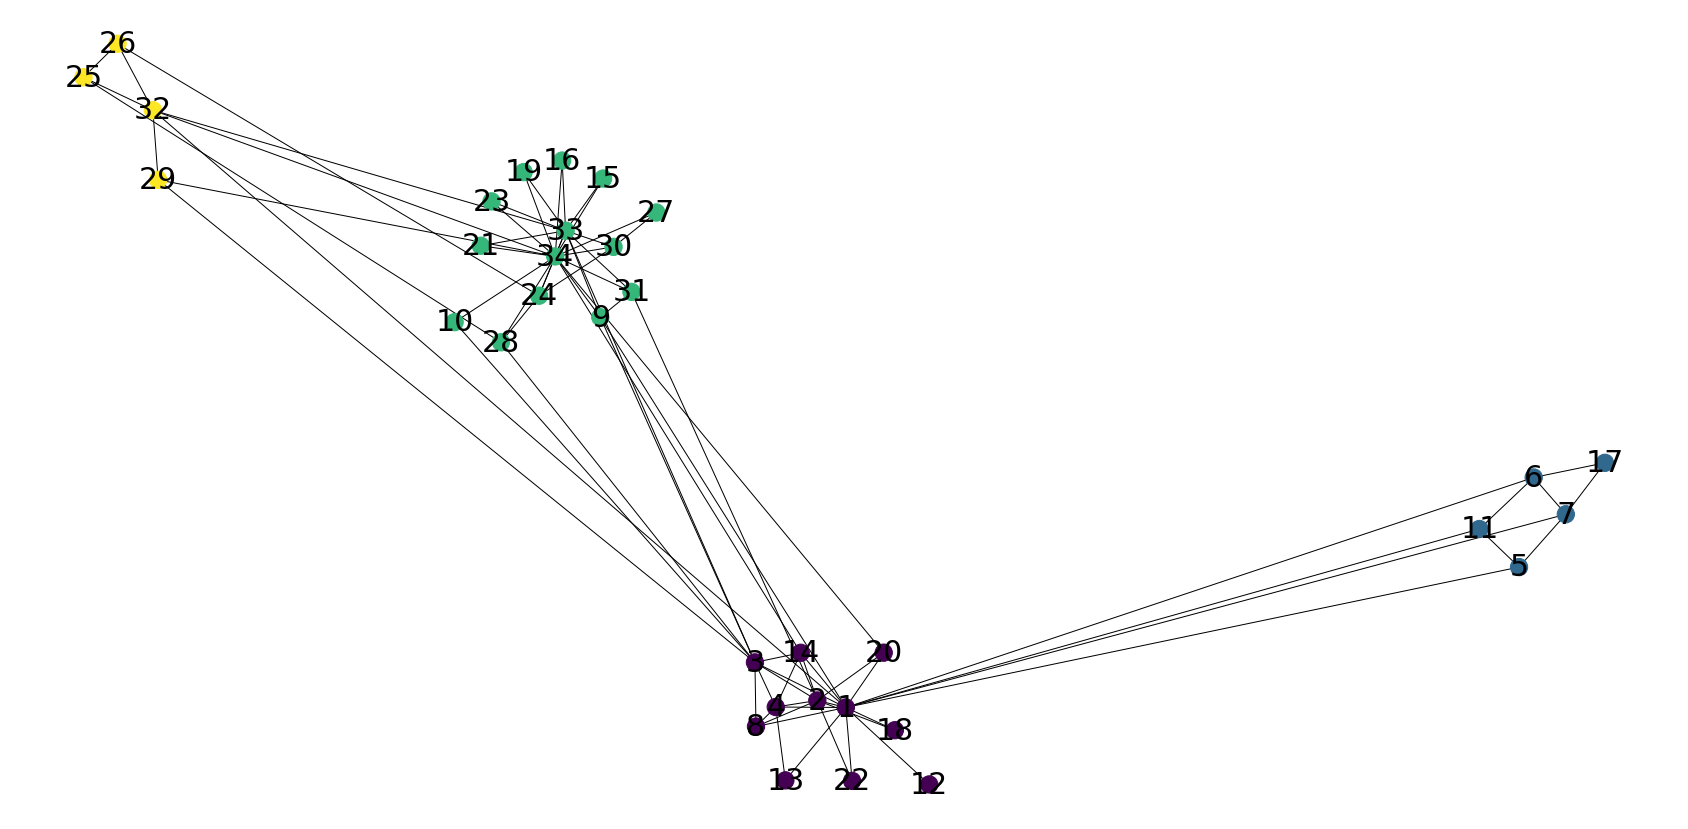

{1: array([  3.73321313, -10.07735852]),
 2: array([ 2.74823157, -9.82959207]),
 3: array([ 0.58919885, -8.49011433]),
 4: array([  1.30903725, -10.06111907]),
 5: array([27.02697489, -5.1352937 ]),
 6: array([27.53461614, -1.98011664]),
 7: array([28.64584313, -3.27529396]),
 8: array([  0.62519048, -10.74834635]),
 9: array([-4.76176002,  3.66012763]),
 10: array([-9.80202995,  3.48651495]),
 11: array([25.65456702, -3.79450341]),
 12: array([  6.6204964 , -12.78625139]),
 13: array([  1.64188081, -12.64317584]),
 14: array([ 2.17284506, -8.15211801]),
 15: array([-4.66272301,  8.5420934 ]),
 16: array([-6.08135776,  9.17564871]),
 17: array([30.        , -1.46480578]),
 18: array([  5.43037048, -10.87749804]),
 19: array([-7.41335335,  8.76789963]),
 20: array([ 5.04430304, -8.14756987]),
 21: array([-8.89707199,  6.17635033]),
 22: array([  3.94999739, -12.66093148]),
 23: array([-8.52530557,  7.73758354]),
 24: array([-6.88095756,  4.41758433]),
 25: array([-22.64493238,  12.10671

In [22]:
def create_graph(A, communities):
    G=nx.Graph()
    
    for nodei in range(A.shape[0]):
        d = {"community": communities[nodei]}
        G.add_node(nodei+1, **d)
    
    for i, j in zip(*A.nonzero()):
        if communities[i] == communities[j]:
            weight = 100
        else:
            weight = 1
        G.add_edge(i+1, j+1, weight=weight)
        
    return G

def plot_graph(G, pos=None):
    plt.figure(figsize=(30,15))  
    
    node_communities = [d["community"] for _, d in G.nodes(data=True)]
    
    if pos==None:
        pos = nx.spring_layout(G, scale=30)  # positions for all nodes
    
    nx.draw_networkx_nodes(G, pos, node_color=node_communities)
    nx.draw_networkx_edges(G, pos)

    nx.draw_networkx_labels(G, pos, font_size=30, font_family='sans-serif')

    plt.axis('off')
    plt.show()
    
    return pos

G = create_graph(A, best_communities)
plot_graph(G)

In [23]:
def modularity_difference(A, communities, m, modularity, vertex, community):
    """
    A: the adjacency matrix of the graph
    communities: vector of communities, on position i the community for node i, so the length of the list equals 
        the number of nodes in the graph 
    m: an integer that equals the sum of all edges in the graph divided by two
    modularity: the modularity of the graph A with communities defined by the variable communities
    vertex: the index of the vertex/node you want to compute the modularity difference for when moving it to community
    community: the community to which you want move the vertex
    """
    #store the vertex' community in a variable
    old_community = communities[vertex] 
    
    new_community_nodes = communities == community
    new_community_nodes[vertex] = False
    old_community_nodes = communities == old_community
    old_community_nodes[vertex] = False
    
    new_k_i_in = np.sum(A[vertex,new_community_nodes])
    old_k_i_in = np.sum(A[vertex,old_community_nodes])
    
    ki = np.sum(A[vertex,:])
    
    new_sum_tot = np.sum(A[new_community_nodes,:])
    old_sum_tot = np.sum(A[old_community_nodes,:])
    
    modularity_difference = (1/m)*(new_k_i_in-old_k_i_in) + (1/(2*m*m))*ki*(old_sum_tot-new_sum_tot)
    
    return modularity_difference

In [24]:
test_A = np.array([
    [0,1,1,0,0,0],
    [1,0,1,0,1,0],
    [1,1,0,0,0,0],
    [0,0,0,0,1,1],
    [0,1,0,1,0,1],
    [0,0,0,1,1,0]
    ]
)
test_communities = np.arange(0,6)
test_m = 0.5*np.sum(A)
test_mod = compute_modularity(test_A, test_communities, test_m)
expected = [
    (0.0,0.0), 
    (0.012327416173,0.012327416174), 
    (0.012491781722,0.012491781723), 
    (-0.00032873110,-0.00032873109), 
    (-0.00049309665,-0.00049309664), 
    (-0.00032873110,-0.00032873109)
]
for vertexi in range(0,6):
    mod_diff = modularity_difference(test_A, test_communities, test_m, test_mod, 0, vertexi)
    lb, ub = expected[vertexi]
    assert lb <= mod_diff <= ub

In [25]:
initial_communities = initialize_communities(A.shape[0])
start_time = time.time()
best_communities = detect_communities(A, initial_communities)
end_time = time.time()
time_faster = end_time-start_time
print(f"Took {time_faster} seconds to execute")

Took 0.10298871994018555 seconds to execute


In [26]:
assert compute_modularity(A, best_communities, m) > 0.4

### We will now compare this naive implementation with a fast implementation of the Louvain method:
https://python-louvain.readthedocs.io/en/latest/

In [27]:
# install the library
!pip install python-louvain

You should consider upgrading via the 'pip install --upgrade pip' command.


In [28]:
import community

In [29]:
# convert adjacency matrix to graph
G=nx.from_numpy_matrix(A)

In [30]:
# compute the best partition
start_time = time.time()
partition = community.best_partition(G)
time_fastest = time.time()-start_time
print(f"Took {time_fastest} seconds to execute")

Took 0.010982036590576172 seconds to execute


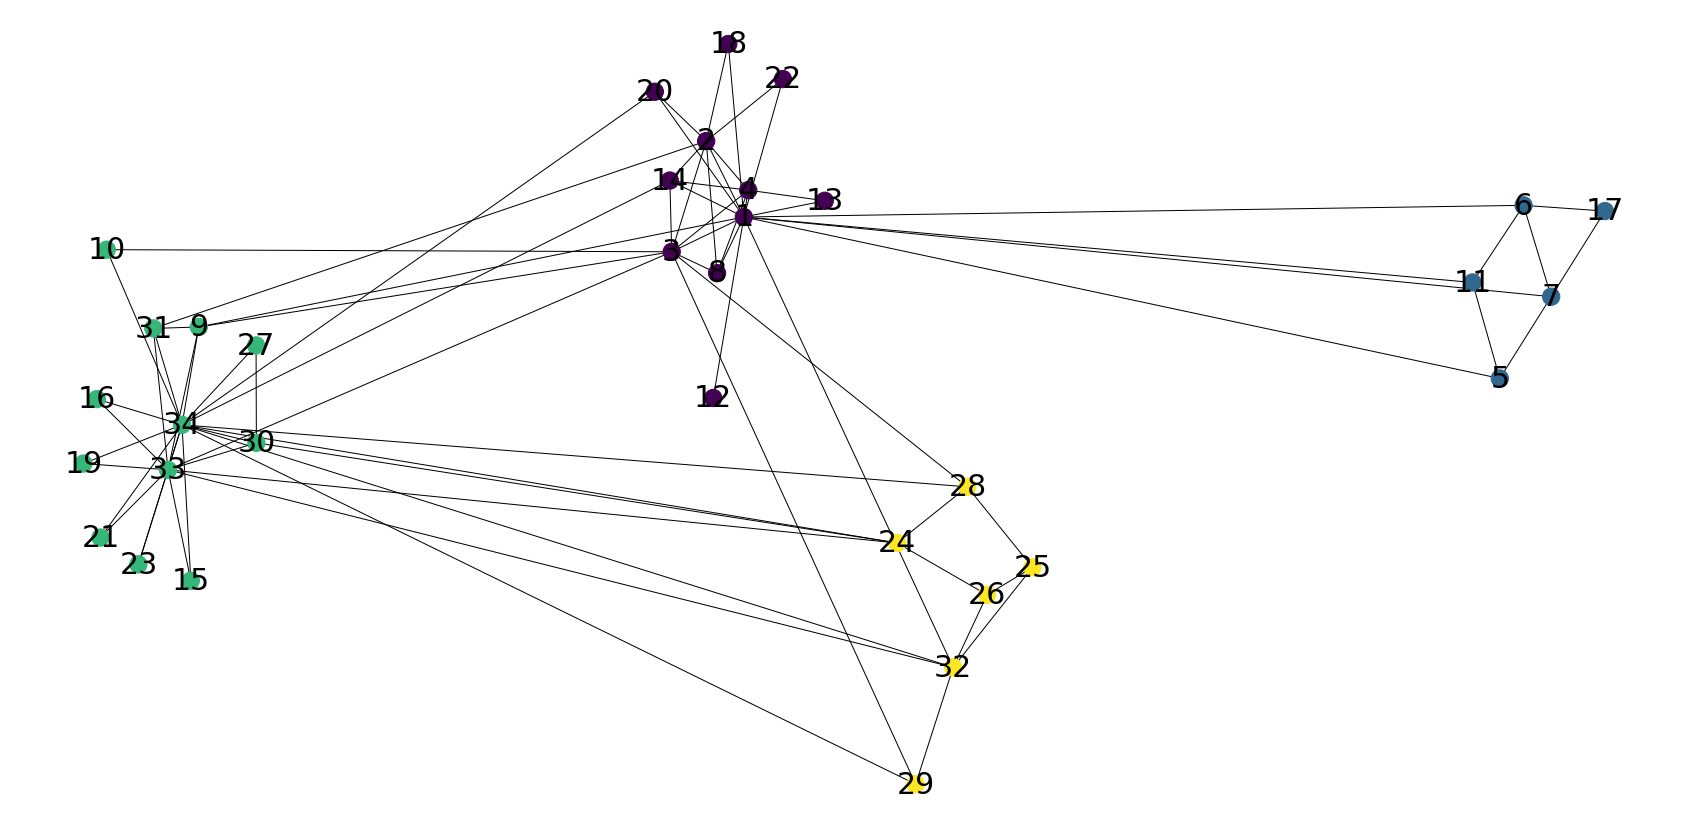

{1: array([1.9124679 , 2.88357228]),
 2: array([0.68474715, 4.42165733]),
 3: array([-0.44014646,  2.17896957]),
 4: array([2.05583866, 3.42731204]),
 5: array([26.57002688, -0.38638716]),
 6: array([27.34557914,  3.11952654]),
 7: array([28.24576019,  1.26951397]),
 8: array([1.03939969, 1.74566048]),
 9: array([-15.86582895,   0.65546628]),
 10: array([-18.86814502,   2.2216259 ]),
 11: array([25.67974436,  1.55718757]),
 12: array([ 0.91549994, -0.78195125]),
 13: array([4.55167341, 3.21244308]),
 14: array([-0.50077373,  3.6222652 ]),
 15: array([-16.12590596,  -4.48321973]),
 16: array([-19.19030088,  -0.80546699]),
 17: array([30.        ,  3.00376508]),
 18: array([1.40546112, 6.38795846]),
 19: array([-19.62796213,  -2.11031714]),
 20: array([-0.99038772,  5.42057982]),
 21: array([-19.07294238,  -3.60985882]),
 22: array([3.18670147, 5.67730254]),
 23: array([-17.83565965,  -4.15229609]),
 24: array([ 6.91183274, -3.71896407]),
 25: array([11.32527061, -4.21403648]),
 26: arra

In [31]:
C = create_graph(A, partition)
plot_graph(C)

In [32]:
fig = go.Figure(data=[go.Bar(
            x=["slow","faster","fastest"], y=[time_slowest, time_faster, time_fastest],
            text=[time_slowest, time_faster, time_fastest],
            textposition='auto',
        )])

fig.show()